In [1]:
#Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import zscore

In [2]:
#Import training set
train_df = pd.read_csv('data/train.csv', index_col="Id")
test_df = pd.read_csv('data/test.csv', index_col="Id")


In [3]:
#Overview of dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

In [4]:
#Check for duplicates
print(f"There is {train_df.duplicated().sum()} duplicates")

There is 0 duplicates


## 1. Visualization of Missing values

In [5]:
#Check for missing values
def calculate_NaN(df: pd.DataFrame, as_percentage: bool = False):
    if as_percentage:
        NaN_df = df.isna().mean() * 100
    else:
        NaN_df = df.isna().sum()
    features_with_missing = NaN_df[NaN_df > 0].sort_values(ascending=False)
    return NaN_df, features_with_missing

def get_categorical_features(df: pd.DataFrame) -> list[str]:
    categorical_features = df.select_dtypes(include=["object"]).columns
    return categorical_features

def get_numerical_features(df: pd.DataFrame) -> list[str]:
    numerical_features = df.select_dtypes(include=[np.number]).columns
    return numerical_features

NaN_df, features_with_missing = calculate_NaN(train_df, True)

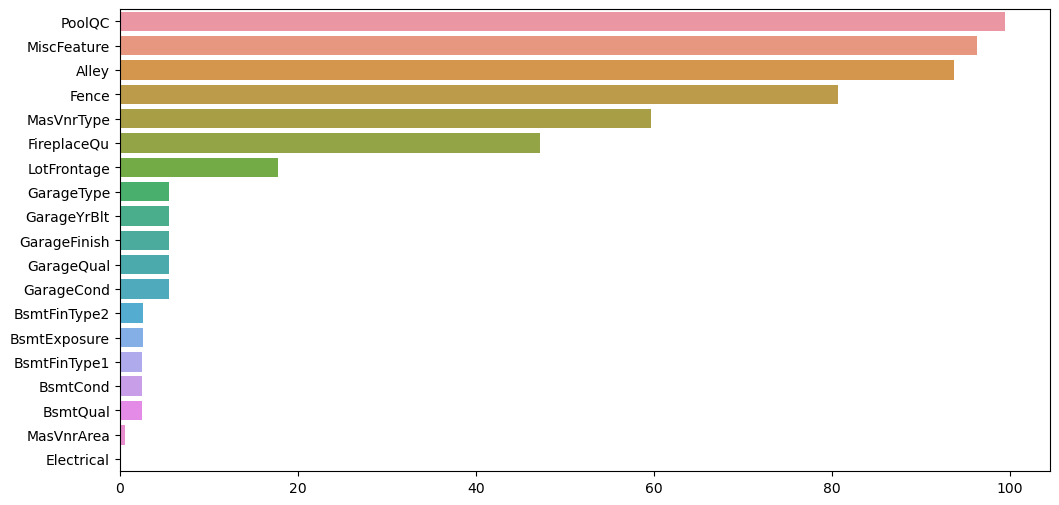

In [6]:
#Plot distribution of missing values
plt.figure(figsize=(12,6))
sns.barplot(y=features_with_missing.index, x=features_with_missing.values)
plt.show()

### 1.1 Handle missing values for categorical features

In [7]:
print(f"Mode of Electrical is {train_df['Electrical'].mode()[0]}")

Mode of Electrical is SBrkr


For all the categorical features with missing values, except from electrical, we can see from the data-description that a missing value (NaN) represents the absence of that feature. Therefore, we can just fill these missing values with the string "NaN" instead of NaN. For electrical we can will the missing value with the mode, which is "SBrKr" (the standard)

In [8]:
#FUNCTION FOR FILLING MISSING VALUES WITH MODE
def fill_with_mode(df: pd.DataFrame, feature: str) -> pd.DataFrame:
    df[feature] = df[feature].mode()[0]
    return df

In [9]:
# FILL MISSING VALUES IN ELECTRICAL WITH MODE
train_df = fill_with_mode(train_df, "Electrical")
print(f"Check that there is no missing values. Missing count: {train_df['Electrical'].isna().sum()}")

Check that there is no missing values. Missing count: 0


In [10]:
#FUNCTION FOR FILLING MISSING VALUES IN THE SPECIFIED FEATURES WITH 'NaN' 
def fill_with_NaNstring(df: pd.DataFrame, features: list[str]) -> pd.DataFrame:
    df[features] = df[features].fillna("NaN")
    return df

In [11]:
#FILLING MISSING VALUES IN CATEGORICAL FEATURES WITH 'NaN'
train_df = fill_with_NaNstring(train_df, get_categorical_features(train_df))

### 1.2 Handle missing values for numerical features

In [12]:
#HELPING FUNCTIONS 

#Function for filling missing values in a feature
def fill_with(df : pd.DataFrame, feature : str, fill_with = 0): 
    df[feature] = df[feature].fillna(fill_with)
    return df
 
#Functions for comparing the values of feature1 and feature2 when feature1 has value NaN   
def compare_NaN_values(feature1, feature2):
    df = train_df[train_df[feature1].isna() == True]
    return df[[feature1, feature2]]

In [13]:
# CHECK WHICH NUMERICAL FEATURES THAT CONTAIN MISSING VALUES
num_features = get_numerical_features(train_df)
num_df = train_df[num_features]
_, num_features_with_missing = calculate_NaN(num_df)
num_features_with_missing

LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
dtype: int64

Will do some more analysis to check the reason behind the missing values in LotFrontage, GarageYrBlt and MasVnrArea. 

#### 1.2.1 MasVnrArea


In [14]:
MasVnrArea_NaN_Type = compare_NaN_values("MasVnrArea", "MasVnrType")
MasVnrArea_NaN_Type

,MasVnrArea,MasVnrType
Id,,
235,NaN,NaN
530,NaN,NaN
651,NaN,NaN
937,NaN,NaN
974,NaN,NaN
978,NaN,NaN
1244,NaN,NaN
1279,NaN,NaN


We observe that for each MasVnrArea value being NaN, the MasVnrType is also NaN. This indicates the absence of a MasVnr and we can set all the missing MasVnrArea values to be 0. 

In [15]:
# FILL MasVnrArea WITH 0
train_df = fill_with(train_df, "MasVnrArea")

#Check if there still is any NaN values (should be False)
train_df["MasVnrArea"].isna().any()

False

#### 1.2.2 GarageYrBlt


In [19]:
GarageYrBlt_NaN_Type = compare_NaN_values('GarageYrBlt', 'GarageType')
print(f"Number of rows: {len(GarageYrBlt_NaN_Type)}, number of rows with 'GarageType' as NaN-value {len(GarageYrBlt_NaN_Type[GarageYrBlt_NaN_Type['GarageType'] == 'NaN'])}")

Number of rows: 81, number of rows with 'GarageType' as NaN-value 81


This means that if GarageYrBlt is NaN it indicates the absence of a garage, and we can set the missing values to be 0. Setting GarageYrBlt to 0 clearly communicates that there is no garage associated with the property

In [ ]:
# FILL GarageYrBlt WITH 0
train_df = fill_with(train_df, "GarageYrBlt")

## 2. Visualization of outliers for numerical features

In [16]:
#GET ALL THE NUMERICAL FEATURES
numerical_features = train_df.select_dtypes(include=[np.number]).columns
numerical_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [17]:
#CHECKING FOR NUMBER OF UNIQUE VALUES 
def unique_values(df: pd.DataFrame, numerical_features):
    temp_list = []
    for feature in numerical_features:
        unique_vals = df[feature].nunique()
        temp_list.append({'feature': feature, 'unique_vals_count': unique_vals})
    unique_vals_df = pd.DataFrame(temp_list)
    return unique_vals_df

unique_values_df = unique_values(train_df, numerical_features)
unique_values_df.sort_values(by="unique_vals_count", ascending=False, inplace=True)
unique_values_df

,feature,unique_vals_count
2,LotArea,1073
15,GrLivArea,861
10,BsmtUnfSF,780
12,1stFlrSF,753
11,TotalBsmtSF,721
36,SalePrice,663
8,BsmtFinSF1,637
26,GarageArea,441
13,2ndFlrSF,417
7,MasVnrArea,327


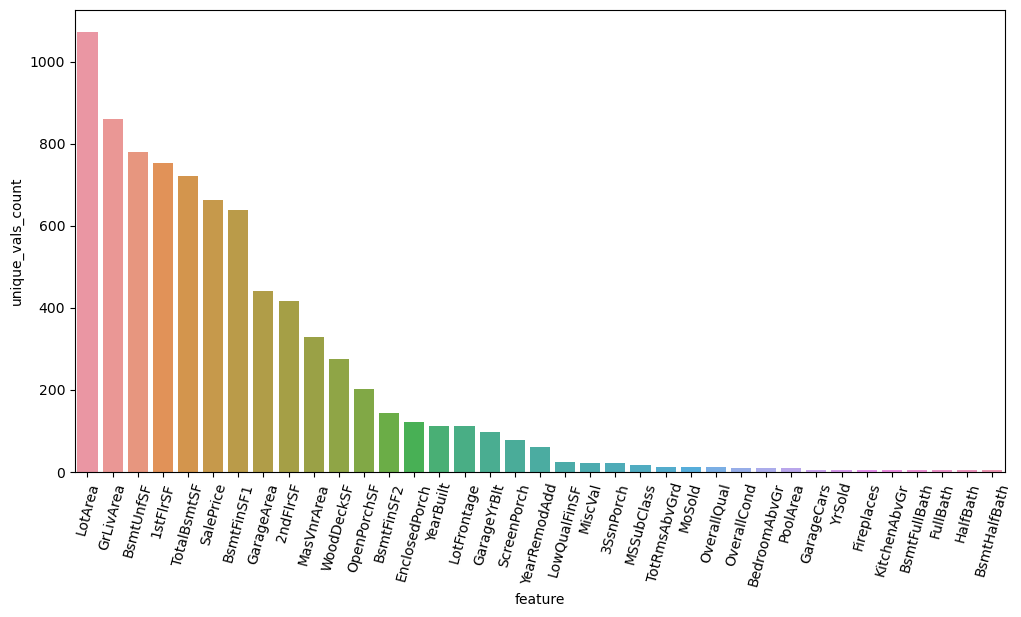

In [18]:
#PLOT NUMBER OF UNIQUE VALUES TO LOOK FOR RELEVANT FEATURES THAT MAY HAVE OUTLINERS
plt.figure(figsize=(12,6))
sns.barplot(data=unique_values_df, y="unique_vals_count", x='feature')
plt.xticks(rotation=75)
plt.show()

In [19]:
#WANT TO LOOK FOR OUTLIERS FOR EVERY FEATURE WITH MORE THAN 50 UNIQUE VALUES
high_unique_features = unique_values_df[unique_values_df["unique_vals_count"] > 50]["feature"].to_list()

In [20]:
def plot_outliers(df : pd.DataFrame, feature : str, target : str = "SalePrice"):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    sns.scatterplot(data=train_df, x=feature, y=target, ax=axes[0])
    sns.boxplot(data=train_df, y=feature, ax=axes[1])
    plt.tight_layout()
    plt.show()

In [21]:
#SCATTERPLOT AND BOXPLOT FOR SELECTED FEATURES
def plot_outliers_features(df : pd.DataFrame, features : list, target : str = "SalePrice"):
    fig, axes = plt.subplots((len(features)), 2, figsize=(8, 50))
    i = 0
    for feature in features:
        sns.scatterplot(data=train_df, x=feature, y=target, ax=axes[i,0])
        sns.boxplot(data=train_df, y=feature, ax=axes[i,1])
        i+=1
    plt.tight_layout()
    plt.show()

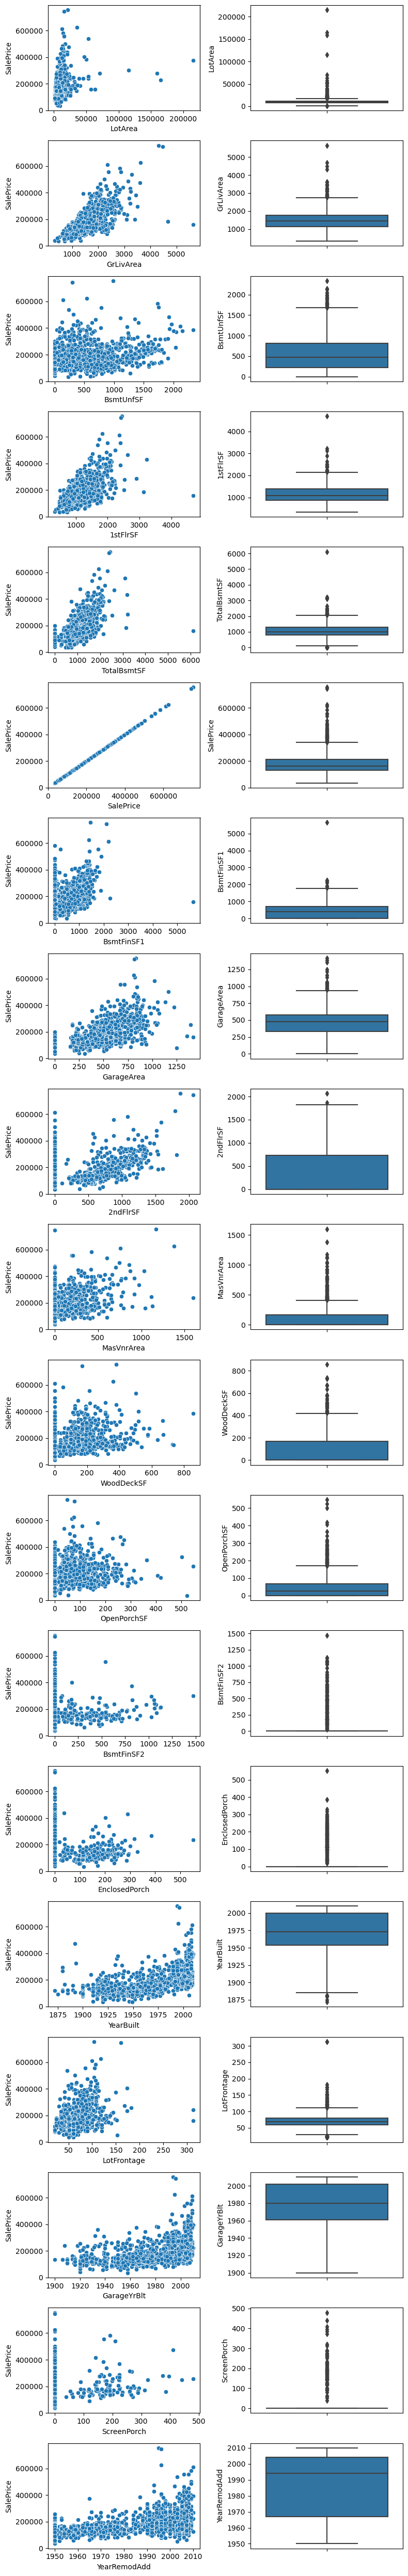

In [22]:
plot_outliers_features(train_df, high_unique_features)

The following features/columns have some outliers: 
- LotFrontage
- LotArea
- GrLivArea
- BsmtFinSF1
- TotalBsmtSF
- 1stFlrSF
- MasVnrArea

To decide the treshhold for remoiving the outliers we do some more analysis of the datapoints for both the train-set and test-set

### 2.2 Outlier analysis to find treshholds

In [23]:
def outlier_analysis(train_df : pd.DataFrame, test_df : pd.DataFrame, feature : str): 
    #Scatterplot of the 50 highest value in the train-set and test-set
    fig, axes = plt.subplots(1,3, figsize = (12,4))
    sns.scatterplot(x = train_df[feature].sort_values(ascending=False)[:50], y=[10] * len(train_df[:50]), label = "Train data", color = "blue", ax = axes[0])
    sns.scatterplot(x=test_df[feature].sort_values(ascending=False)[:50], y=[20] * len(test_df[:50]), label = "Test data",color = "red", ax = axes[0])
    axes[0].set_title(f"Fig1: Scatter Plot of {feature} comparing train and test data", fontsize = 10)
    axes[0].grid(True, linestyle='--', alpha=0.5)
    
    #CDF plot of both datasets.  
    sns.ecdfplot(x= train_df[feature], color = "blue", label="Train data", ax = axes[1])
    sns.ecdfplot(test_df[feature], label="Test data", color="red", ax=axes[1])
    axes[1].set_title(f"Fig2: CDF of {feature}", fontsize = 10)
    axes[1].grid(True, linestyle="--", alpha=0.5)
    outlier_threshold = train_df[feature].quantile(0.99)
    axes[1].axvspan(outlier_threshold, train_df[feature].max(), color="red", alpha=0.1, label="Potential Outliers")
    axes[1].legend()
    
    #Scatterplot of all datapoints in trainset with respect to the SalePrice
    sns.scatterplot(train_df, x = feature, y = "SalePrice", ax = axes[2])
    axes[2].set_title(f"Fig 3: Scatterplot of {feature} with respect to SalePrice", fontsize = 10)
    plt.tight_layout()
    plt.show()

#### 2.2.1 LotArea

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


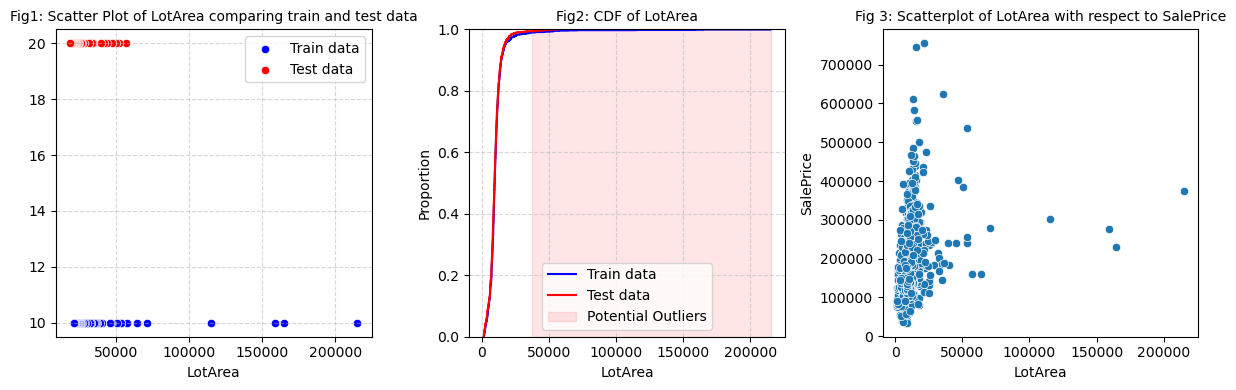

In [24]:
#LOTAREA
outlier_analysis(train_df, test_df, "LotArea")

In Figure 1, we observe a few data points with LotArea values exceeding 100,000, which appear to be outliers, as they are significantly larger than the majority of the data points. Notably, such high values are absent in the test set, suggesting these extreme cases are unique to the training data.

In Figure 3, we can see that these data points with exceptionally high LotArea values do not correspond to proportionally high SalePrice values. Instead, they tend to have relatively low SalePrice values, indicating that these large LotArea properties might not follow the typical relationship between LotArea and SalePrice seen in the rest of the dataset.

Therefore we drop the values above 100000.

In [25]:
#DROP ENTRIES IN TRAIN_DF WITH "LotArea" > 100000
train_df = train_df[train_df["LotArea"] < 100000]

#### 2.2.2 LotFrontage

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


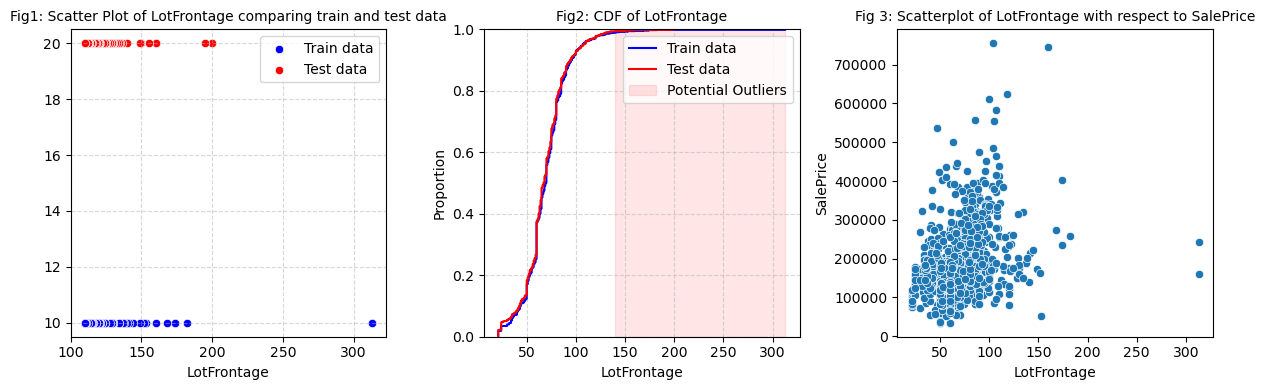

In [26]:
#LOTFRONTAGE
outlier_analysis(train_df, test_df, "LotFrontage")

For LotFrontage, we identify two outliers in the training set with values exceeding 200. These points deviate substantially from the main cluster of data and have no counterparts in the test set, highlighting their uniqueness to the training data.

As shown in the last figure, these high LotFrontage values do not exhibit a clear relationship with SalePrice, indicating that they may be anomalies or extreme cases that don’t align with the general trend of the data. Given their deviation and lack of predictive value, we will exclude all LotFrontage values above 200 from further analysis.

In [27]:
#DROP ENTRIES IN TRAIN_DF WITH "LotFrontage" > 200
train_df = train_df[train_df["LotFrontage"] < 200]

#### 2.2.3 GrLivArea

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


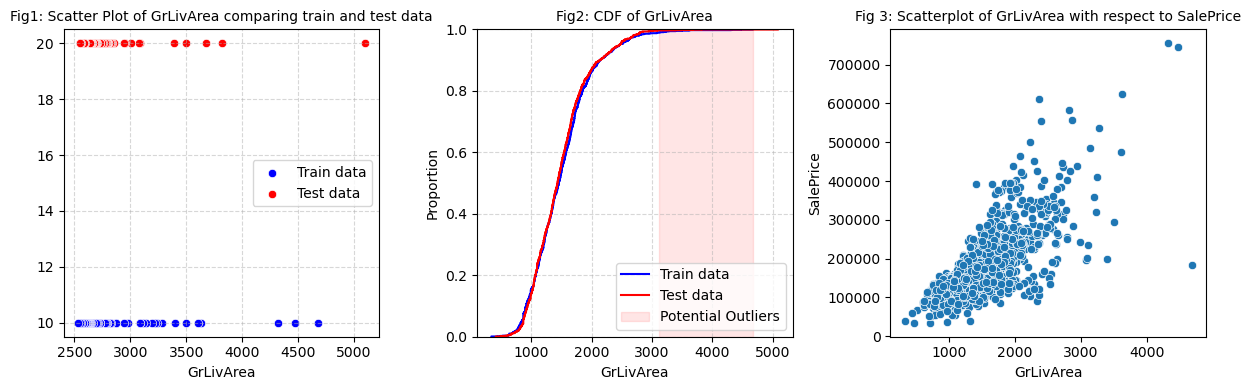

In [28]:
outlier_analysis(train_df, test_df, "GrLivArea")

We observe a single outlier in the traning set for *GrLivArea* with a value exceeding 4500 and an unusually low SalePrice.Therefore, we will exclude this data point from further analysis. Also since there is only one datapoint in the trainset with such a high value, it will do with removing the high datapoint from the training-set- 

In [29]:
#DROP ENTRIES IN TRAIN_DF WITH "GrLivArea" > 4500
train_df = train_df[train_df["GrLivArea"] < 4500]

#### 2.2.4 BsmtFinSF1

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


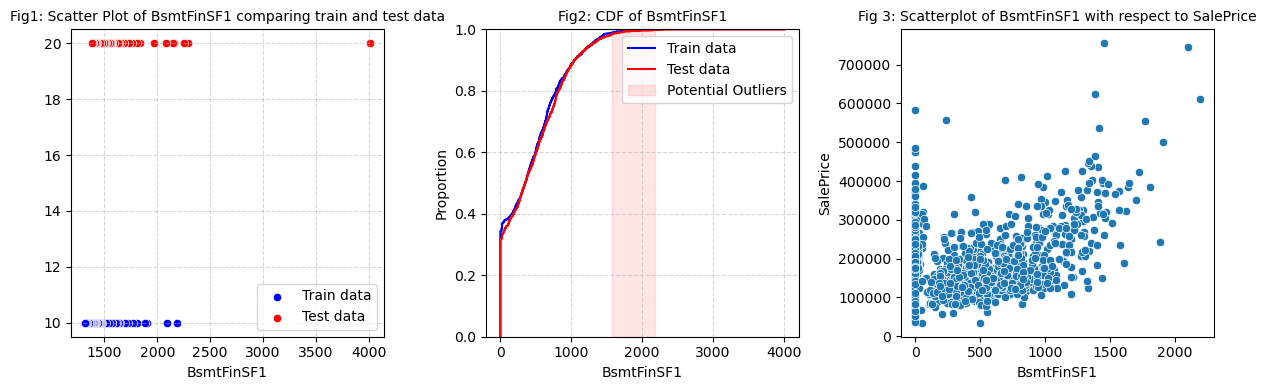

In [30]:
outlier_analysis(train_df, test_df, 'BsmtFinSF1')

For BsmtFinSF1, we observe that the only outlier with a value exceeding 3000 with comparatively low SalePrice has already been removed. Therefore, no additional values need to be dropped from this feature.

#### 2.2.5 TotalBsmtSF

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


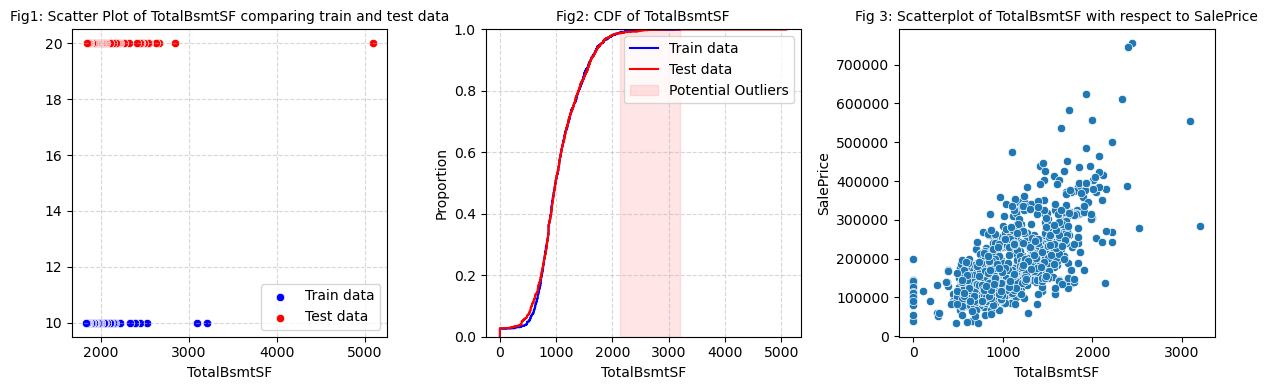

In [31]:
outlier_analysis(train_df, test_df, 'TotalBsmtSF')

The outliers for TotalBsmt exceeding 5000 has already been removed, so no additional values are being dropped. 

#### 2.2.6.1stFlrSF

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


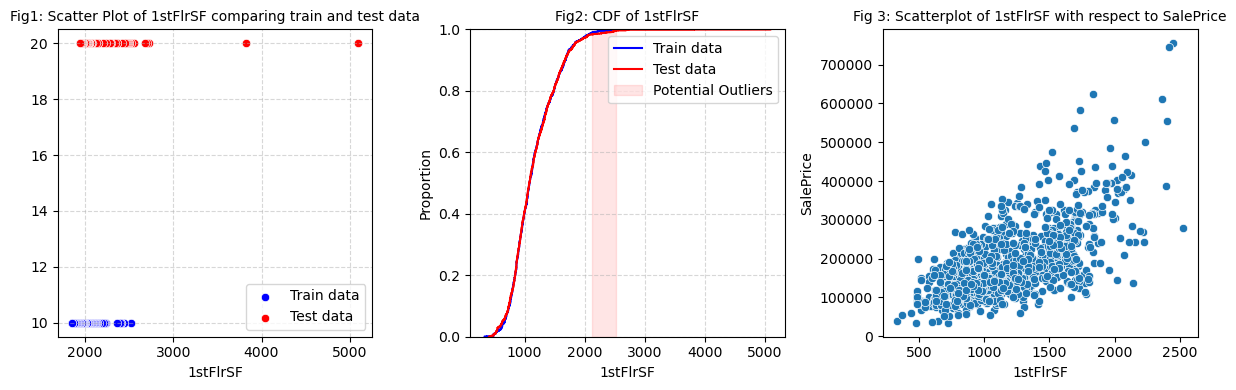

In [32]:
outlier_analysis(train_df, test_df, '1stFlrSF')

The outliers for 1stFlrSF exceeding 3000 has already been removed, so no additional values are being dropped. 

#### 2.2.7 MasVnrArea

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


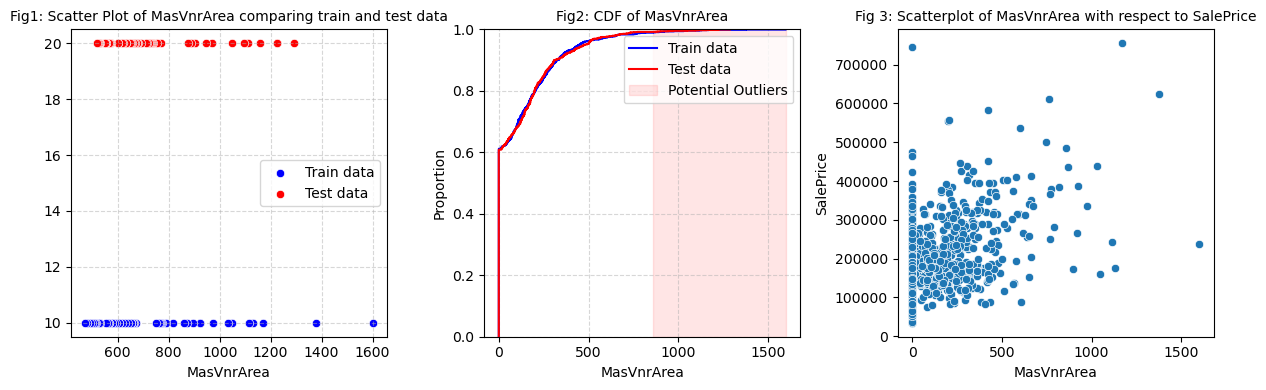

In [33]:
outlier_analysis(train_df, test_df, 'MasVnrArea')

We observe one outlier in the traning set for *MasVnrArea* with a value exceeding 1500 and a comparatively low SalePrice. Therefore, we will drop this value from the training-set. 

In [34]:
#DROP ENTRIES IN TRAIN_DF WITH "MasVnrArea" > 1500
train_df = train_df[train_df["MasVnrArea"] < 1500]